# Sentence classification by MorphConv
Implementation of [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) to classify sentiment of movie review

### Explanation of this notebook
* Dataset : [Naver sentiment movie corpus v1.0](https://github.com/e9t/nsmc)
    + train, validation : splitting `ratings_train.txt` (150k reviews) for train (120k reviews) and validation (30k reviews)
    + test : `ratings_test.txt` (50k reviews)
* Preprocessing
    + Morphological analysis by Mecab wrapped by [konlpy](http://konlpy.org/en/latest/)
    + Using [FastText](https://arxiv.org/abs/1607.04606) embedding by [gluonnlp package](https://gluon-nlp.mxnet.io/)

### Setup

In [40]:
import os
import sys

import numpy as np
np.random.seed(7)
import pandas as pd

from collections import Counter 

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (Input, Embedding, Conv1D, AveragePooling1D, 
                          concatenate, Bidirectional, GRU, Dense)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# import khaiii
import re

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

### Loading dataset

In [16]:
ratings_train = pd.read_csv('data/ratings_train.txt', sep = '\t')[['document', 'label']]
ratings_test = pd.read_csv('data/ratings_test.txt', sep = '\t')[['document', 'label']]

# ratings, ratings_tst의 document column에 nan 값이 있으므로 이를 빈 문자열로 대체
print(sum(ratings_train.document.isna()), sum(ratings_test.document.isna()))

ratings_train.document[ratings_train.document.isna()] = ''
ratings_test.document[ratings_test.document.isna()] = ''

print(sum(ratings_train.document.isna()), sum(ratings_test.document.isna()))

5 3
0 0


### Use khaiii for preprocessing

In [3]:
def make_morphs(text):
#     tag_list = ['NNG', 'NNP', 'NNB', 'NP', 'NR', 'VV', 'VA', 
#             'VX', 'VCP', 'VCN', 'MM', 'MAG', 'MAJ', 'IC']
    tag_list = ['NNG', 'NNP', 'NP', 'NR', 'VV', 'VA', 'VX', 'VCP', 'VCN',
                'MM', 'MAG', 'MAJ', 'IC', 'SN', 'SW', 'SWK', 'SO', 'XR',
                'SH', 'SL', 'ZN', 'ZV', 'SP', 'SE']

#     text = re.sub('[^ㅎㅎ|^^|ㅡ|\-|~|;|♥|♡|★|ㅠ|ㅜ|a-z|A-Z|ㄱ-ㅎ|가-힣|\'|\"|\,|\.|\!|\?|\d]', 
#                   ' ', text)
    text = re.sub('(ㅡ.ㅡ|-.-)', ' ㅡㅡ ', text)
    text = re.sub('(ㅡ|-){2,}', ' ㅡㅡ ', text)
    text = re.sub('(ㄱ-ㅎ|^){2,}', ' \g<1>\g<1> ', text)
    text = re.sub('(♥|♡)+', ' ♥♥ ', text)
    text = re.sub('(★|;|~)+', ' \g<1>\g<1> ', text)
    text = re.sub('[ㅠ|ㅜ]+', ' ㅠ ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    if not text:
        return ''

    result = api.analyze(text) 
    result_word = [m.lex+'다' if m.tag.startswith('V') else m.lex
                       for word in result
                          for m in word.morphs
                            if m.tag in tag_list]
    result_words = '+'.join(result_word)
    result_words = result_words.replace('^+^', '^^')
    result_words = result_words.replace('ㅠ', 'ㅠㅠ')
    return result_words

In [4]:
api = khaiii.KhaiiiApi()
api.open()

Path: /usr/local/lib/python3.6/dist-packages/khaiii


In [5]:
%%time
# train
print('Make train morphs......')
ratings_train['morphs'] = ratings_train['document'].apply(make_morphs)

# test
print('Make test morphs......')
ratings_test['morphs'] = ratings_test['document'].apply(make_morphs)

Make train morphs......
Make test morphs......
CPU times: user 3min 25s, sys: 400 ms, total: 3min 26s
Wall time: 3min 26s


In [6]:
api.close()

In [7]:
ratings_train.to_csv('data/ratings_train_khaiii.txt', sep='\t', index=False)
ratings_test.to_csv('data/ratings_test_khaiii.txt', sep='\t', index=False)

### Reload data

In [2]:
ratings = pd.read_csv('data/ratings_train_khaiii.txt', sep = '\t')[['morphs', 'label']]
ratings_test = pd.read_csv('data/ratings_test_khaiii.txt', sep = '\t')[['morphs', 'label']]

# ratings, ratings_tst의 document column에 nan 값이 있으므로 이를 빈 문자열로 대체
print(sum(ratings.morphs.isna()), sum(ratings_test.morphs.isna()))

ratings.morphs[ratings.morphs.isna()] = ''
ratings_test.morphs[ratings_test.morphs.isna()] = ''

print(sum(ratings.morphs.isna()), sum(ratings_test.morphs.isna()))

89 29
0 0


### Preprocessing dataset

##### Find best random seed trought rasidual and varience

In [93]:
# print('Find best seed......')

# min_seed = 0
# min_residual = 100000000
# for i in tqdm(range(10000)):
#     x_data = ratings.morphs.apply(split_word).tolist()
#     y_data = ratings.label.tolist()

#     x_train_word, x_val_word, y_train, y_val = train_test_split(x_data, y_data,
#                                                                 test_size=0.2,
#                                                                 random_state=i,
#                                                                 stratify=y_data)
#     # print(len(y_train), sum(y_train), len(y_val), sum(y_val))

#     word_table = list(set([word for words in x_data for word in words]))
#     word_table = {word:0 for word in word_table}

#     train_counter = nlp.data.count_tokens(itertools.chain.from_iterable([c for c in x_train_word]))
#     train_table = word_table.copy()
#     train_table.update(train_counter)

#     val_counter = nlp.data.count_tokens(itertools.chain.from_iterable([c for c in x_val_word]))
#     val_table = word_table.copy()
#     val_table.update(val_counter)

#     train_cnt = np.array(list(train_table.values()))
#     val_cnt = np.array(list(val_table.values())) * 4
    
#     residual = np.abs(train_cnt-val_cnt).sum()
#     if residual < min_residual:
#         min_residual = residual
#         min_seed = i
#         print('seed:', i)
#         print(min_residual)
#         print(np.var(train_cnt), np.var(val_cnt))

Find best seed......


seed: 0
280028
73093.95535086525 72788.64036922259
seed: 4
279283
72659.20509965229 74530.59328873192
seed: 8
277420
72949.85140907383 73359.04609988058
seed: 108
276936
73050.30235850641 72953.05609298393
seed: 128
276021
73141.69375567777 72588.56850242332
seed: 267
275940
73197.65236750114 72370.5584639531
seed: 1069
275647
73067.3642571775 72884.91745579352
seed: 1395
275052
73194.207448039 72384.66283194325
seed: 4843
274889
73004.69947935347 73136.23770602426
seed: 5107
274502
73130.34417974179 72631.76975883021


### Make training data 

In [3]:
def split_word(text):
#     return text.split('+')
    return [word for word in text.split('+')]

In [4]:
print('Make train, val data......')

x_data = ratings.morphs.apply(split_word).tolist()
y_data = ratings.label.tolist()

x_train_word, x_val_word, y_train, y_val = train_test_split(x_data, y_data,
                                                            test_size=0.2,
                                                            random_state=108,
                                                            stratify=y_data)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

Make train, val data......


In [5]:
keywords = x_data

In [6]:
np.median([len(k) for k in keywords]), len(keywords)

(8.0, 150000)

In [7]:
keyword_cnt = Counter([i for item in keywords for i in item])

In [8]:
# keyword_clip_dict = dict(keyword_clip)
keyword_clip_dict = {key:value for key, value in keyword_cnt.items() if value >= 3}
keyword_dict = dict(zip(keyword_clip_dict.keys(), range(len(keyword_clip_dict))))

In [9]:
#공백과 미학습 단어 처리를 위한 사전 정보 추가
keyword_dict['_PAD_'] = len(keyword_dict)
keyword_dict['_UNK_'] = len(keyword_dict)

In [11]:
#리뷰 시퀀스 단어수의 중앙값 +10를 max 리뷰 시퀀스로 정함... 
# max_seq = np.median([len(k) for k in keywords]) + 10
max_seq = 20

In [12]:
def encoding_and_padding(corp_list, dic, max_seq=50):
    from keras.preprocessing.sequence import pad_sequences
    coding_seq = [ [dic.get(j, dic['_UNK_']) for j in i]  for i in corp_list ]
    #일반적으로 리뷰는 마지막 부분에 많은 정보를 포함할 가능성이 많아 패딩은 앞에 준다. 
    return(pad_sequences(coding_seq, maxlen=max_seq, padding='pre', truncating='pre',value=dic['_PAD_']))

In [13]:
x_train = encoding_and_padding(x_train_word, keyword_dict, max_seq=int(max_seq))
x_val = encoding_and_padding(x_val_word, keyword_dict, max_seq=int(max_seq))

In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((120000, 20), (120000,), (30000, 20), (30000,))

### Define MorphConv class

In [17]:
inputs = Input(shape=(x_train.shape[1],), name='input')
embeddings_out = Embedding(input_dim=len(keyword_dict), 
                           output_dim=50,
                           name='embedding')(inputs)

conv0 = Conv1D(32, 1, padding='same')(embeddings_out)
conv1 = Conv1D(16, 2, padding='same')(embeddings_out)
conv2 = Conv1D(8, 3, padding='same')(embeddings_out)

pool0 = AveragePooling1D()(conv0)
pool1 = AveragePooling1D()(conv1)
pool2 = AveragePooling1D()(conv2)

concat_layer = concatenate([pool0, pool1, pool2],axis=2)

bidir = Bidirectional(GRU(10, recurrent_dropout=0.2, dropout=0.2))(concat_layer)

out = Dense(1,activation='sigmoid')(bidir)

model = Model(inputs=[inputs,], outputs=out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       1180450     input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 20, 32)       1632        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 20, 16)       1616        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

In [35]:
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

# model.compile(loss='binary_crossentropy', 
#               optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
#               metrics=['accuracy'])

### Training

In [25]:
# hyper-parameter
# lr = 0.003
epochs = 3 # 30
# batch_size = 10000
batch_size = 1000

In [26]:
model_path = 'checkpoint/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

# early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [27]:
hist = model.fit( x=x_train, y=y_train, 
                  batch_size=batch_size, epochs=epochs, 
                  validation_data=[x_val, y_val],
                  shuffle=True, callbacks = [checkpointer] )
#                  shuffle=True, callbacks = [checkpointer, early_stopping] )

Train on 120000 samples, validate on 30000 samples
Epoch 1/3
120000/120000 [==============================] - 17s 140us/step - loss: 0.3808 - val_loss: 0.3838

Epoch 00001: val_loss improved from inf to 0.38384, saving model to checkpoint/01-0.3838.hdf5
Epoch 2/3
120000/120000 [==============================] - 16s 130us/step - loss: 0.3494 - val_loss: 0.3702

Epoch 00002: val_loss improved from 0.38384 to 0.37024, saving model to checkpoint/02-0.3702.hdf5
Epoch 3/3
120000/120000 [==============================] - 16s 131us/step - loss: 0.3320 - val_loss: 0.3683

Epoch 00003: val_loss improved from 0.37024 to 0.36832, saving model to checkpoint/03-0.3683.hdf5


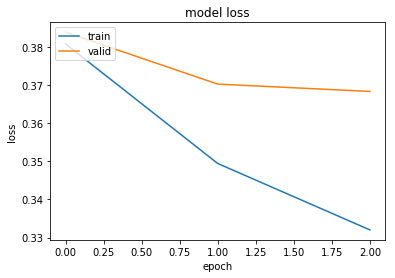

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Test

In [32]:
# Make test data
print('Make test data......')
x_test_word = ratings_test.morphs.apply(split_word).tolist()
x_test = encoding_and_padding(x_test_word, keyword_dict, max_seq=int(max_seq))
y_test = np.asarray(ratings_test.label.tolist())

Make test data......


In [33]:
x_test.shape, y_test.shape

((50000, 20), (50000,))

In [28]:
# model_path = 'checkpoint/'
# model = load_model(model_path+'85-0.0714.hdf5')

INFO:tensorflow:Restoring parameters from checkpoints/014_0352_0366.ckpt


INFO:tensorflow:Restoring parameters from checkpoints/014_0352_0366.ckpt


In [36]:
# prob = model.predict(x_test)

[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

50000/50000 [==============================] - 6s 114us/step
Loss: 0.38160418176651 Accuracy: 0.83188


In [37]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

F1 Score: 0.8265588247431189
